In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.experimental import Adagrad
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import random
import pickle

# from keras_visualizer import visualizer 

In [12]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU') ) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.0.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.0.0
Scikit-Learn 1.2.2
GPU is available


### Load the training set and testing set

In [29]:
imputed_train_data = pd.read_csv('/Users/yihongan/Desktop/lr_imputed_train.csv')
imputed_test_data = pd.read_csv('/Users/yihongan/Desktop/lr_imputed_test.csv')

### Preprogress both textual and numerical features

In [122]:
# Define input shapes
text_input_shape = (100,)
num_input_shape = (imputed_train_data.shape[1] - 2,)

# Tokenize textual data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, filters='', char_level=True)
tokenizer.fit_on_texts(''.join(imputed_train_data['url']))
vocab_size = len(tokenizer.word_index) + 1

# Textual data
text_train = pad_sequences(tokenizer.texts_to_sequences(imputed_train_data['url']), maxlen=text_input_shape[0], padding="post")
text_test = pad_sequences(tokenizer.texts_to_sequences(imputed_test_data['url']), maxlen=text_input_shape[0], padding="post")

# Numerical data
num_train = imputed_train_data.iloc[:, 1:(num_input_shape[0] + 1)].values
num_test = imputed_test_data.iloc[:, 1:(num_input_shape[0] + 1)].values

mean_sd_sc = StandardScaler()
num_train_std = mean_sd_sc.fit_transform(num_train)
num_test_std = mean_sd_sc.transform(num_test)

# Response
y_train = imputed_train_data.iloc[:, (num_input_shape[0] + 1)].values
y_test = imputed_test_data.iloc[:, (num_input_shape[0] + 1)].values.squeeze()

### Save the std scaler and tokenizer

In [31]:
pickle.dump(mean_sd_sc, open('/Users/yihongan/Desktop/std_sc.pkl', 'wb'))
pickle.dump(tokenizer, open('/Users/yihongan/Desktop/tokenizer.pkl', 'wb'))

### Define the CNN model that accept both textual and numerical features for classification

In [32]:
def phising_CNNModel(vocab_size, embedding_size=128, conv_num=1, conv_filters=32, conv_kernel_size=5, conv_activation='relu',
                    fc_num=3, fc_units=64, fc_activation='relu', fc_dropout=0.2, learning_rate=0.001, optimizer="Adam"):
    
    # Define the input tensors
    text_input = Input(shape=text_input_shape, name='text_input')
    num_input = Input(shape=num_input_shape, name='num_input')
        
    # Apply the embedding layer to the textual input
    text_embedding = Embedding(vocab_size, embedding_size, input_length=text_input_shape[0])(text_input)

    # Apply the convolutional layers to the textual input
    for num in range(conv_num):
        if num == 0:
            text_conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation=conv_activation, padding='valid')(text_embedding)
        else:
            text_conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation=conv_activation, padding='valid')(text_conv)
    
    # Apply the global max pooling layer before fully-connected layers
    text_pool = GlobalMaxPooling1D()(text_conv)
    
    # Concatenate the textual and numeric features
    concat = Concatenate()([text_pool, num_input])

    # Apply the fully connected layers to the concatenated features
    for num in range(fc_num):
        if num == 0:
            fc = Dense(units=fc_units, activation=fc_activation)(concat)
        else:
            fc = Dense(units=fc_units, activation=fc_activation)(fc)
        fc = Dropout(fc_dropout)(fc)

    # Apply the output layer to the fully connected output
    output = Dense(units=1, activation='sigmoid')(fc)

    # Define the model
    model = Model(inputs=[text_input, num_input], outputs=output)
    
    # Define optimizer
    if optimizer == 'Adam':
        optim = Adam(learning_rate)
    elif optimizer == 'SGD':
        optim = SGD(learning_rate)
    elif optimizer == 'RMSprop':
        optim = RMSprop(learning_rate)
    elif optimizer == 'Adagrad':
        optim = Adagrad(learning_rate)

    # Compile the model
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

    return model

### Define the function for K-fold Cross validation

In [57]:
def cross_validate(cv, model, param, text_train, num_train, y_train, scaler=None, verbose=0):
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(num_train, y_train)):
        print('Fold', fold + 1)

        # Define the training set and validation set 
        X_text_train, X_num_train, Y_train = text_train[train_idx] ,num_train[train_idx], y_train[train_idx]
        X_text_val, X_num_val, Y_val = text_train[val_idx], num_train[val_idx], y_train[val_idx]
        
        # Tokenize the url data
        tokenizer = Tokenizer(num_words=num_words, filters='', char_level=True)
        tokenizer.fit_on_texts(''.join(X_text_train))
        vocab_size = len(tokenizer.word_index) + 1

        # Textual data
        X_text_train = pad_sequences(tokenizer.texts_to_sequences(X_text_train), maxlen=text_input_shape[0], padding="post")
        X_text_val = pad_sequences(tokenizer.texts_to_sequences(X_text_val), maxlen=text_input_shape[0], padding="post")
            
        # Normalize the num_train
        if scaler != None:
            X_num_train = scaler.fit_transform(X_num_train)
            X_num_val = scaler.transform(X_num_val)
            
        # Define the model
        train_model = model(vocab_size=vocab_size, embedding_size=param[0], conv_num=param[1], conv_filters=param[2], conv_kernel_size=param[3], 
                            conv_activation=param[4], fc_num=param[5], fc_units=param[6], fc_activation=param[7], 
                            fc_dropout=param[8], learning_rate=param[9], optimizer=param[10])
            
        # Build and train the model
        early_stopping = EarlyStopping(monitor="val_loss", patience=3)
        train_model.fit([X_text_train, X_num_train], Y_train, 
                        batch_size=param[11], epochs=30, 
                        validation_split=0.1, 
                        callbacks=[early_stopping], verbose=verbose)

        # Evaluate the model on the train and the val set
        train_metrix = train_model.evaluate([X_text_train, X_num_train], Y_train, verbose=verbose)
        val_metrix = train_model.evaluate([X_text_val, X_num_val], Y_val, verbose=verbose)
            
        # Accuracy scores
        train_score = train_metrix[1]
        val_score = val_metrix[1]
        train_scores.append(train_score)
        val_scores.append(val_score)
            
        # Loss
        train_loss = train_metrix[0]
        val_loss = val_metrix[0]
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Report the scores
        print(f"Training accuracy = {train_score:.4f} & training loss = {train_loss:.4f}")
        print(f"Validation accuracy = {val_score:.4f} & validation loss = {val_loss:.4f}")

    # Report the 5-folder scores and losses
    print(f'5-folders CV training accuracy = {np.mean(train_scores)} & loss = {np.mean(train_losses)}')
    print(f'5-folders CV validation accuracy = {np.mean(val_scores)} & loss = {np.mean(val_losses)}')
    return np.mean(train_scores), np.mean(train_losses), np.mean(val_scores), np.mean(val_losses)

### Initial model

In [54]:
initial_model = phising_CNNModel(vocab_size=vocab_size, embedding_size=128, conv_num=1, conv_filters=32, conv_kernel_size=5, conv_activation='relu',
                                fc_num=3, fc_units=64, fc_activation='relu', fc_dropout=0.2, learning_rate=0.001, optimizer='Adam')
initial_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 100, 128)     8192        ['text_input[0][0]']             
                                                                                                  
 conv1d_15 (Conv1D)             (None, 96, 32)       20512       ['embedding_15[0][0]']           
                                                                                                  
 global_max_pooling1d_15 (Globa  (None, 32)          0           ['conv1d_15[0][0]']              
 lMaxPooling1D)                                                                            

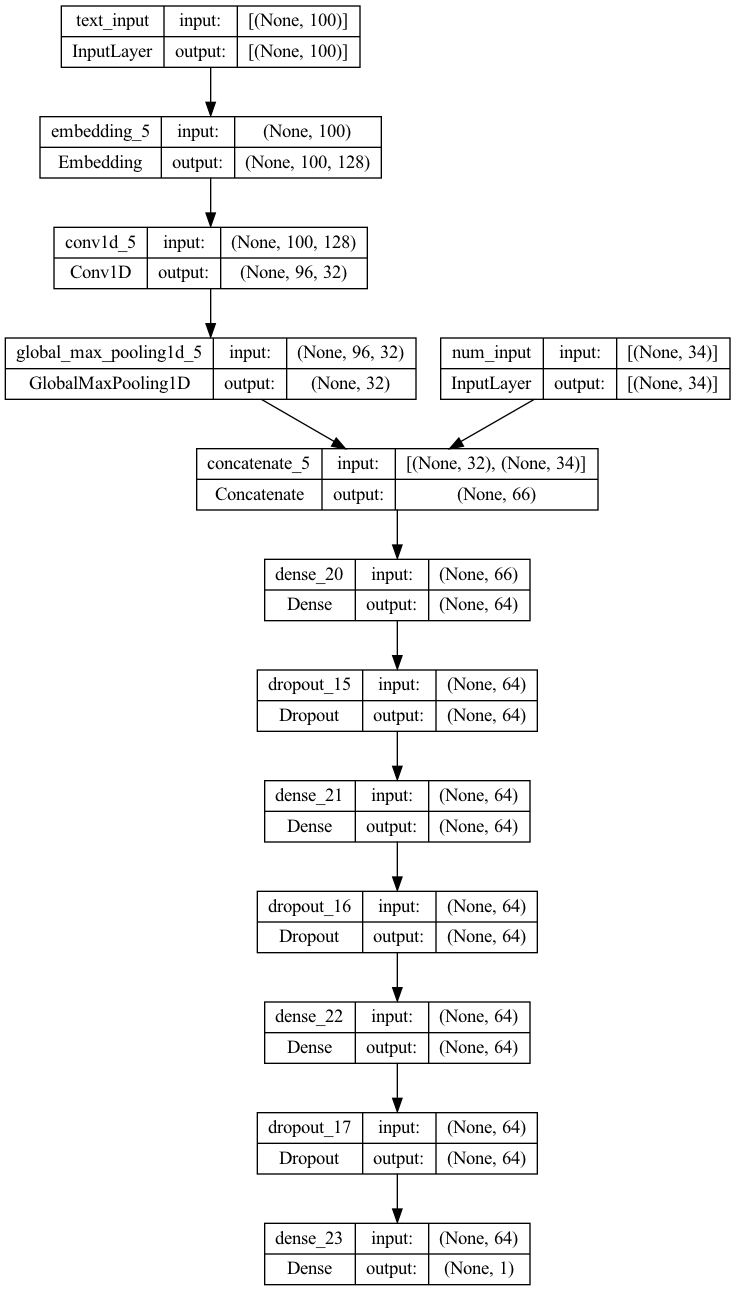

In [44]:
keras.utils.plot_model(initial_model, '/Users/yihongan/Desktop/initCNN_arch.png', show_shapes=True)

In [45]:
# Define the cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=4012)

In [58]:
init_parm = [128, 1, 32, 5, 'relu', 3, 64, 'relu', 0.2, 0.001, 'Adam', 32]
initial_score = cross_validate(cv, phising_CNNModel, init_parm, imputed_train_data['url'], num_train, y_train, scaler=mean_sd_sc, verbose=1)

Fold 1
Epoch 1/30
319/319 [==============================] - 8s 22ms/step - loss: 0.3189 - accuracy: 0.8701 - val_loss: 0.1965 - val_accuracy: 0.9162
Epoch 2/30
319/319 [==============================] - 6s 17ms/step - loss: 0.1937 - accuracy: 0.9228 - val_loss: 0.1577 - val_accuracy: 0.9294
Epoch 3/30
319/319 [==============================] - 5s 16ms/step - loss: 0.1505 - accuracy: 0.9430 - val_loss: 0.1669 - val_accuracy: 0.9338
Epoch 4/30
319/319 [==============================] - 5s 16ms/step - loss: 0.1234 - accuracy: 0.9542 - val_loss: 0.1389 - val_accuracy: 0.9409
Epoch 5/30
319/319 [==============================] - 5s 17ms/step - loss: 0.1081 - accuracy: 0.9623 - val_loss: 0.1239 - val_accuracy: 0.9435
Epoch 6/30
319/319 [==============================] - 5s 16ms/step - loss: 0.0880 - accuracy: 0.9691 - val_loss: 0.1309 - val_accuracy: 0.9444
Epoch 7/30
319/319 [==============================] - 5s 17ms/step - loss: 0.0703 - accuracy: 0.9757 - val_loss: 0.1673 - val_accuracy:

In [59]:
best_socre = initial_score[2]
best_socre

0.9451271176338196

### Define the function for random search

In [63]:
def random_search(cv, model, param_dist, text_train, num_train, y_train, int_score=0, scaler=None, seed=None, i_ter=10, verbose=0):
    train_cv_scores = []
    train_cv_losses = []
    val_cv_scores = []
    val_cv_losses = []
    
    best_score = int_score
    best_param = []
    
    for i in range(i_ter):
        print(f'Search {i +1}')
        # Select parameters
        if seed != None:
            random.seed(seed + i)
        param = [random.choice(param_dist[item]) for item in param_dist]
        print(f'Combination = {param}')
        
        # CV
        cv_score = cross_validate(cv, phising_CNNModel, param, text_train, num_train, y_train, scaler=scaler, verbose=verbose)
        train_cv_scores.append(cv_score[0])
        train_cv_losses.append(cv_score[1])
        val_cv_scores.append(cv_score[2])
        val_cv_losses.append(cv_score[3])
        
        if val_cv_scores[i] > best_score:
            best_score = val_cv_scores[i]
            best_param = param

    return best_param, best_score, train_cv_scores, train_cv_losses, val_cv_scores, val_cv_losses

In [64]:
# Define the search space for your hyperparameters
param_dist = {
    'embedding_size': [64, 128, 256],
    'conv_num': [1, 2, 3],
    'conv_filters': [32, 64, 128],
    'conv_kernel_size': [3, 5],
    'conv_activation': ['relu', 'sigmoid'],
    'fc_num': [2, 3, 4],
    'fc_units': [64, 128, 256],
    'fc_activation': ['relu', 'sigmoid'],
    'fc_dropout': [0.0, 0.2, 0.4],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'batch_size': [32]
}

In [65]:
CNN_search = random_search(cv, phising_CNNModel, param_dist, imputed_train_data['url'], num_train, y_train, 
                           int_score=best_socre, scaler=mean_sd_sc, seed=4012, i_ter=10, verbose=1)

Search 1
Combination = [64, 3, 128, 5, 'relu', 2, 64, 'relu', 0.0, 0.001, 'Adam', 32]
Fold 1
Epoch 1/30
319/319 [==============================] - 9s 23ms/step - loss: 0.3017 - accuracy: 0.8743 - val_loss: 0.2262 - val_accuracy: 0.9082
Epoch 2/30
319/319 [==============================] - 6s 18ms/step - loss: 0.1931 - accuracy: 0.9200 - val_loss: 0.1583 - val_accuracy: 0.9409
Epoch 3/30
319/319 [==============================] - 6s 18ms/step - loss: 0.1552 - accuracy: 0.9404 - val_loss: 0.1592 - val_accuracy: 0.9294
Epoch 4/30
319/319 [==============================] - 6s 17ms/step - loss: 0.1279 - accuracy: 0.9523 - val_loss: 0.1443 - val_accuracy: 0.9435
Epoch 5/30
319/319 [==============================] - 5s 17ms/step - loss: 0.1041 - accuracy: 0.9613 - val_loss: 0.1259 - val_accuracy: 0.9444
Epoch 6/30
319/319 [==============================] - 6s 17ms/step - loss: 0.0780 - accuracy: 0.9728 - val_loss: 0.1177 - val_accuracy: 0.9550
Epoch 7/30
319/319 [=============================

In [66]:
print(f'Best combination of parameters = {CNN_search[0]}')
print(f'Best score = {CNN_search[1]}')

Best combination of parameters = [256, 2, 64, 3, 'relu', 3, 128, 'relu', 0.0, 0.001, 'Adam', 32]
Best score = 0.9537429451942444


In [67]:
best_param = [256, 2, 64, 3, 'relu', 3, 128, 'relu', 0.0, 0.001, 'Adam', 32]

### Comparing optimizers, learning rate and batchs

In [123]:
train_idx, val_idx = list(cv.split(num_train, y_train))[0]

# Define the training set and validation set 
X_text_train, X_num_train, Y_train = imputed_train_data['url'][train_idx] ,num_train[train_idx], y_train[train_idx]
X_text_val, X_num_val, Y_val = imputed_train_data['url'][val_idx], num_train[val_idx], y_train[val_idx]

# Tokenize the url data
tokenizer = Tokenizer(num_words=num_words, filters='', char_level=True)
tokenizer.fit_on_texts(''.join(X_text_train))
X_vocab_size = len(tokenizer.word_index) + 1

# Textual data
X_text_train = pad_sequences(tokenizer.texts_to_sequences(X_text_train), maxlen=text_input_shape[0], padding="post")
X_text_val = pad_sequences(tokenizer.texts_to_sequences(X_text_val), maxlen=text_input_shape[0], padding="post")

# Normalize the num_train
X_num_train = mean_sd_sc.fit_transform(X_num_train)
X_num_val = mean_sd_sc.transform(X_num_val)

In [125]:
best_model = phising_CNNModel(vocab_size=X_vocab_size, embedding_size=best_param[0], conv_num=best_param[1], conv_filters=best_param[2], conv_kernel_size=best_param[3], 
                              conv_activation=best_param[4], fc_num=best_param[5], fc_units=best_param[6], fc_activation=best_param[7], 
                              fc_dropout=best_param[8], learning_rate=best_param[9], optimizer=best_param[10])

best_model.summary()

Model: "model_83"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 embedding_83 (Embedding)       (None, 100, 256)     16128       ['text_input[0][0]']             
                                                                                                  
 conv1d_154 (Conv1D)            (None, 98, 64)       49216       ['embedding_83[0][0]']           
                                                                                                  
 conv1d_155 (Conv1D)            (None, 96, 64)       12352       ['conv1d_154[0][0]']             
                                                                                           

### Optimizer

In [70]:
# Define list of optimizers to compare
optimizers = [Adam(0.001), SGD(0.001), RMSprop(0.001)]
opt_histories = []

# Train and evaluate the model with each optimizer
for optimizer in optimizers:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit([X_text_train, X_num_train], Y_train,
                              batch_size=32,
                              epochs=10,
                              verbose=1,
                              validation_data=([X_text_val, X_num_val], Y_val))
     opt_histories.append(history)

Epoch 1/10
354/354 [==============================] - 14s 34ms/step - loss: 0.2458 - accuracy: 0.8996 - val_loss: 0.1724 - val_accuracy: 0.9283
Epoch 2/10
354/354 [==============================] - 9s 26ms/step - loss: 0.1559 - accuracy: 0.9402 - val_loss: 0.1504 - val_accuracy: 0.9442
Epoch 3/10
354/354 [==============================] - 8s 22ms/step - loss: 0.1164 - accuracy: 0.9557 - val_loss: 0.1326 - val_accuracy: 0.9537
Epoch 4/10
354/354 [==============================] - 7s 21ms/step - loss: 0.0927 - accuracy: 0.9664 - val_loss: 0.1315 - val_accuracy: 0.9537
Epoch 5/10
354/354 [==============================] - 7s 19ms/step - loss: 0.0731 - accuracy: 0.9733 - val_loss: 0.1170 - val_accuracy: 0.9587
Epoch 6/10
354/354 [==============================] - 7s 20ms/step - loss: 0.0597 - accuracy: 0.9794 - val_loss: 0.1274 - val_accuracy: 0.9566
Epoch 7/10
354/354 [==============================] - 7s 19ms/step - loss: 0.0462 - accuracy: 0.9847 - val_loss: 0.1359 - val_accuracy: 0.959

Text(0.5, 0, 'Epoch')

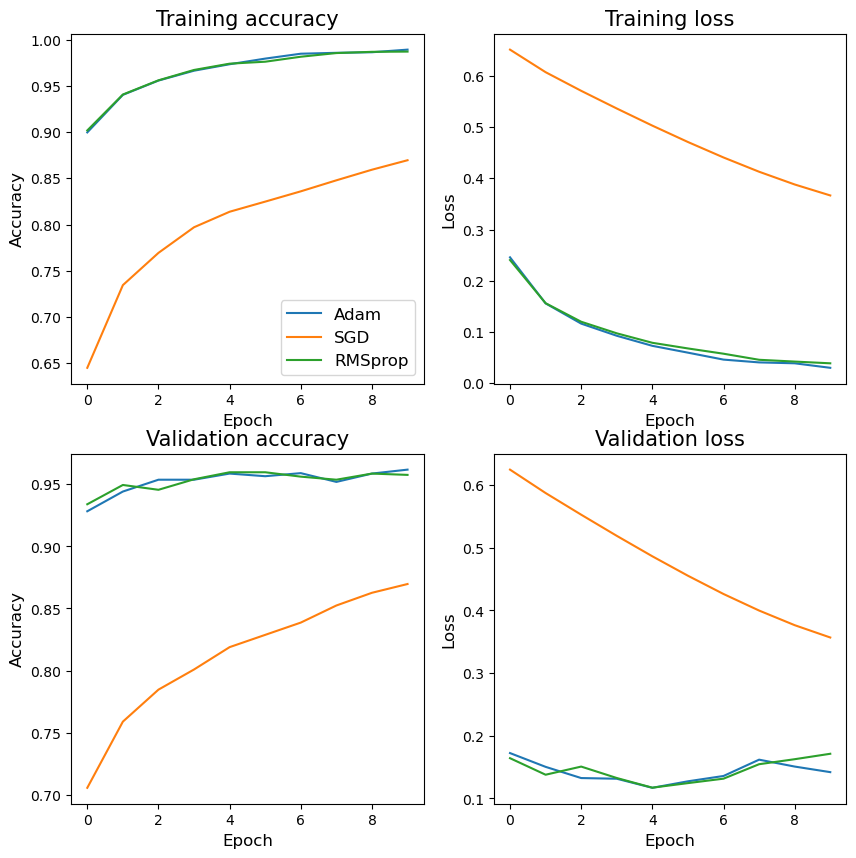

In [72]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(opt_histories[0].history['accuracy'])
plt.plot(opt_histories[1].history['accuracy'])
plt.plot(opt_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Adam', 'SGD', 'RMSprop'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(opt_histories[0].history['loss'])
plt.plot(opt_histories[1].history['loss'])
plt.plot(opt_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(opt_histories[0].history['val_accuracy'])
plt.plot(opt_histories[1].history['val_accuracy'])
plt.plot(opt_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(opt_histories[0].history['val_loss'])
plt.plot(opt_histories[1].history['val_loss'])
plt.plot(opt_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)


### Learning rate

In [73]:
# Define list of optimizers to compare
learning_rates = [0.01, 0.001, 0.0001]
lr_histories = []

# Train and evaluate the model with each optimizer
for learning_rate in learning_rates:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit([X_text_train, X_num_train], Y_train,
                              batch_size=32,
                              epochs=10,
                              verbose=1,
                              validation_data=([X_text_val, X_num_val], Y_val))
     lr_histories.append(history)

Epoch 1/10
354/354 [==============================] - 11s 28ms/step - loss: 0.2738 - accuracy: 0.8921 - val_loss: 0.2195 - val_accuracy: 0.9128
Epoch 2/10
354/354 [==============================] - 7s 19ms/step - loss: 0.2215 - accuracy: 0.9130 - val_loss: 0.2309 - val_accuracy: 0.9008
Epoch 3/10
354/354 [==============================] - 6s 16ms/step - loss: 0.2102 - accuracy: 0.9144 - val_loss: 0.2077 - val_accuracy: 0.9149
Epoch 4/10
354/354 [==============================] - 6s 16ms/step - loss: 0.1943 - accuracy: 0.9173 - val_loss: 0.2122 - val_accuracy: 0.9230
Epoch 5/10
354/354 [==============================] - 6s 16ms/step - loss: 0.1920 - accuracy: 0.9212 - val_loss: 0.2296 - val_accuracy: 0.9153
Epoch 6/10
354/354 [==============================] - 6s 16ms/step - loss: 0.1904 - accuracy: 0.9251 - val_loss: 0.1813 - val_accuracy: 0.9248
Epoch 7/10
354/354 [==============================] - 6s 16ms/step - loss: 0.1840 - accuracy: 0.9259 - val_loss: 0.2101 - val_accuracy: 0.921

Text(0.5, 0, 'Epoch')

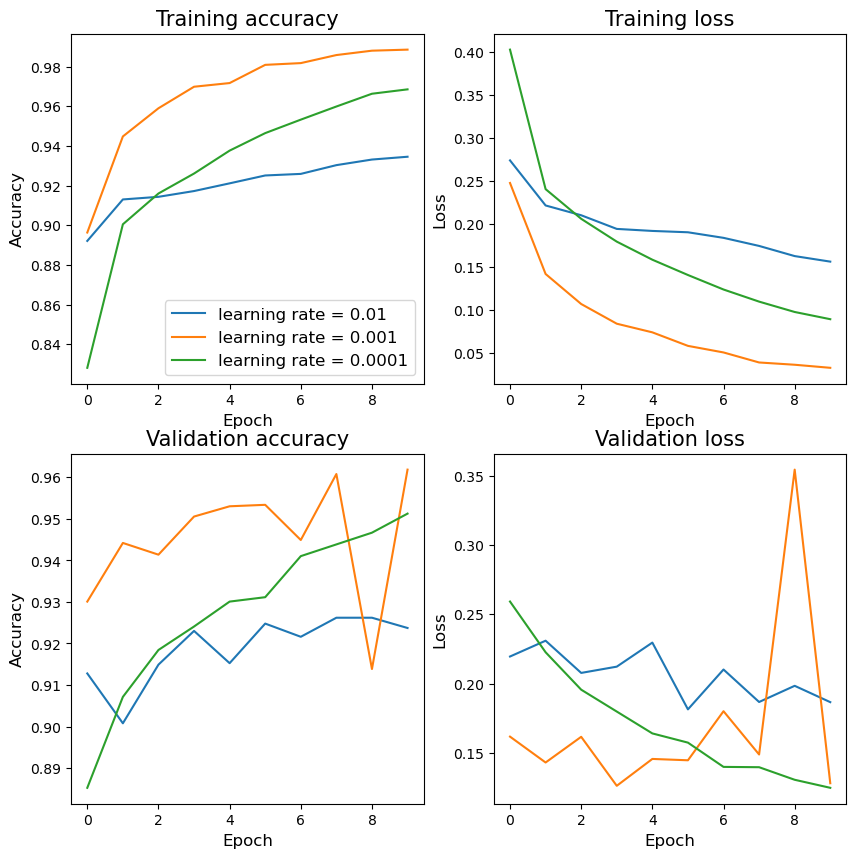

In [74]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(lr_histories[0].history['accuracy'])
plt.plot(lr_histories[1].history['accuracy'])
plt.plot(lr_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['learning rate = 0.01', 'learning rate = 0.001', 'learning rate = 0.0001'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(lr_histories[0].history['loss'])
plt.plot(lr_histories[1].history['loss'])
plt.plot(lr_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(lr_histories[0].history['val_accuracy'])
plt.plot(lr_histories[1].history['val_accuracy'])
plt.plot(lr_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(lr_histories[0].history['val_loss'])
plt.plot(lr_histories[1].history['val_loss'])
plt.plot(lr_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

### Batch size

In [126]:
# Define list of optimizers to compare
batch_sizes = [16, 32, 64]
bs_histories = []

# Train and evaluate the model with each optimizer
for batch_size in batch_sizes:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit([X_text_train, X_num_train], Y_train,
                              batch_size=batch_size,
                              epochs=10,
                              verbose=1,
                              validation_data=([X_text_val, X_num_val], Y_val))
     bs_histories.append(history)

Epoch 1/10
708/708 [==============================] - 23s 30ms/step - loss: 0.2374 - accuracy: 0.9057 - val_loss: 0.1632 - val_accuracy: 0.9322
Epoch 2/10
708/708 [==============================] - 13s 19ms/step - loss: 0.1516 - accuracy: 0.9428 - val_loss: 0.1605 - val_accuracy: 0.9368
Epoch 3/10
708/708 [==============================] - 11s 16ms/step - loss: 0.1158 - accuracy: 0.9579 - val_loss: 0.1412 - val_accuracy: 0.9439
Epoch 4/10
708/708 [==============================] - 11s 16ms/step - loss: 0.0939 - accuracy: 0.9652 - val_loss: 0.1151 - val_accuracy: 0.9552
Epoch 5/10
708/708 [==============================] - 11s 16ms/step - loss: 0.0777 - accuracy: 0.9703 - val_loss: 0.1234 - val_accuracy: 0.9569
Epoch 6/10
708/708 [==============================] - 11s 16ms/step - loss: 0.0645 - accuracy: 0.9755 - val_loss: 0.1402 - val_accuracy: 0.9559
Epoch 7/10
708/708 [==============================] - 11s 15ms/step - loss: 0.0573 - accuracy: 0.9785 - val_loss: 0.1464 - val_accuracy:

Text(0.5, 0, 'Epoch')

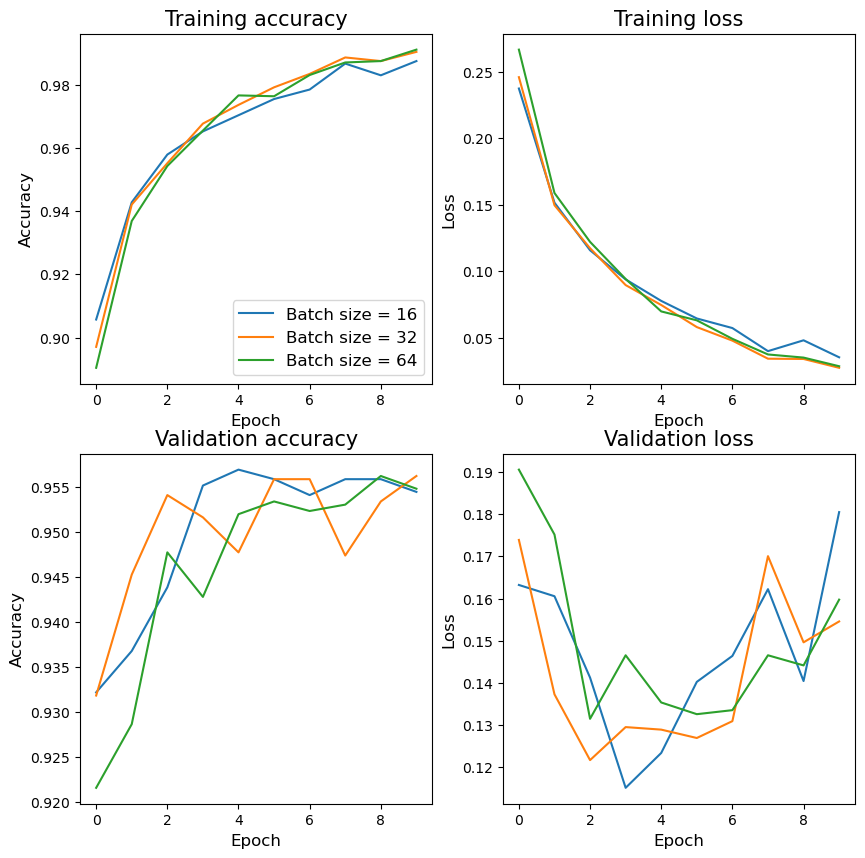

In [127]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(bs_histories[0].history['accuracy'])
plt.plot(bs_histories[1].history['accuracy'])
plt.plot(bs_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Batch size = 16', 'Batch size = 32', 'Batch size = 64'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(bs_histories[0].history['loss'])
plt.plot(bs_histories[1].history['loss'])
plt.plot(bs_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(bs_histories[0].history['val_accuracy'])
plt.plot(bs_histories[1].history['val_accuracy'])
plt.plot(bs_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(bs_histories[0].history['val_loss'])
plt.plot(bs_histories[1].history['val_loss'])
plt.plot(bs_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

### Retrain the model with best hyperparameters

In [128]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [133]:
best_model = phising_CNNModel(vocab_size=vocab_size, embedding_size=256, conv_num=2, 
                              conv_filters=64, conv_kernel_size=3, 
                              conv_activation='relu', fc_num=3, 
                              fc_units=128, fc_activation='relu', 
                              fc_dropout=0.0, learning_rate=0.001, optimizer='Adam')

In [134]:
history = best_model.fit([text_train, num_train_std], y_train, epochs=30, 
                         batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/30
399/399 [==============================] - 20s 46ms/step - loss: 0.2352 - accuracy: 0.9037 - val_loss: 0.1483 - val_accuracy: 0.9428
Epoch 2/30
399/399 [==============================] - 11s 28ms/step - loss: 0.1436 - accuracy: 0.9444 - val_loss: 0.1373 - val_accuracy: 0.9513
Epoch 3/30
399/399 [==============================] - 8s 21ms/step - loss: 0.1095 - accuracy: 0.9602 - val_loss: 0.1274 - val_accuracy: 0.9520
Epoch 4/30
399/399 [==============================] - 7s 18ms/step - loss: 0.0856 - accuracy: 0.9700 - val_loss: 0.1122 - val_accuracy: 0.9583
Epoch 5/30
399/399 [==============================] - 7s 18ms/step - loss: 0.0699 - accuracy: 0.9747 - val_loss: 0.1235 - val_accuracy: 0.9605
Epoch 6/30
399/399 [==============================] - 7s 17ms/step - loss: 0.0595 - accuracy: 0.9788 - val_loss: 0.1072 - val_accuracy: 0.9626
Epoch 7/30
399/399 [==============================] - 7s 18ms/step - loss: 0.0515 - accuracy: 0.9808 - val_loss: 0.1301 - val_accuracy: 0.96

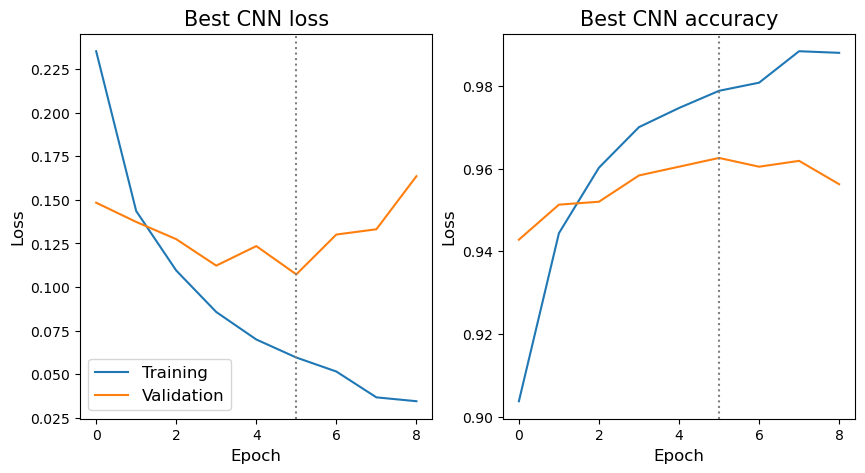

In [135]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Best CNN loss", fontsize=15)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.axvline(x=5, color='grey',linestyle=":")
plt.legend(["Training", "Validation"], loc="best", fontsize=12)

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Best CNN accuracy", fontsize=15)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.axvline(x=5, color='grey',linestyle=":")

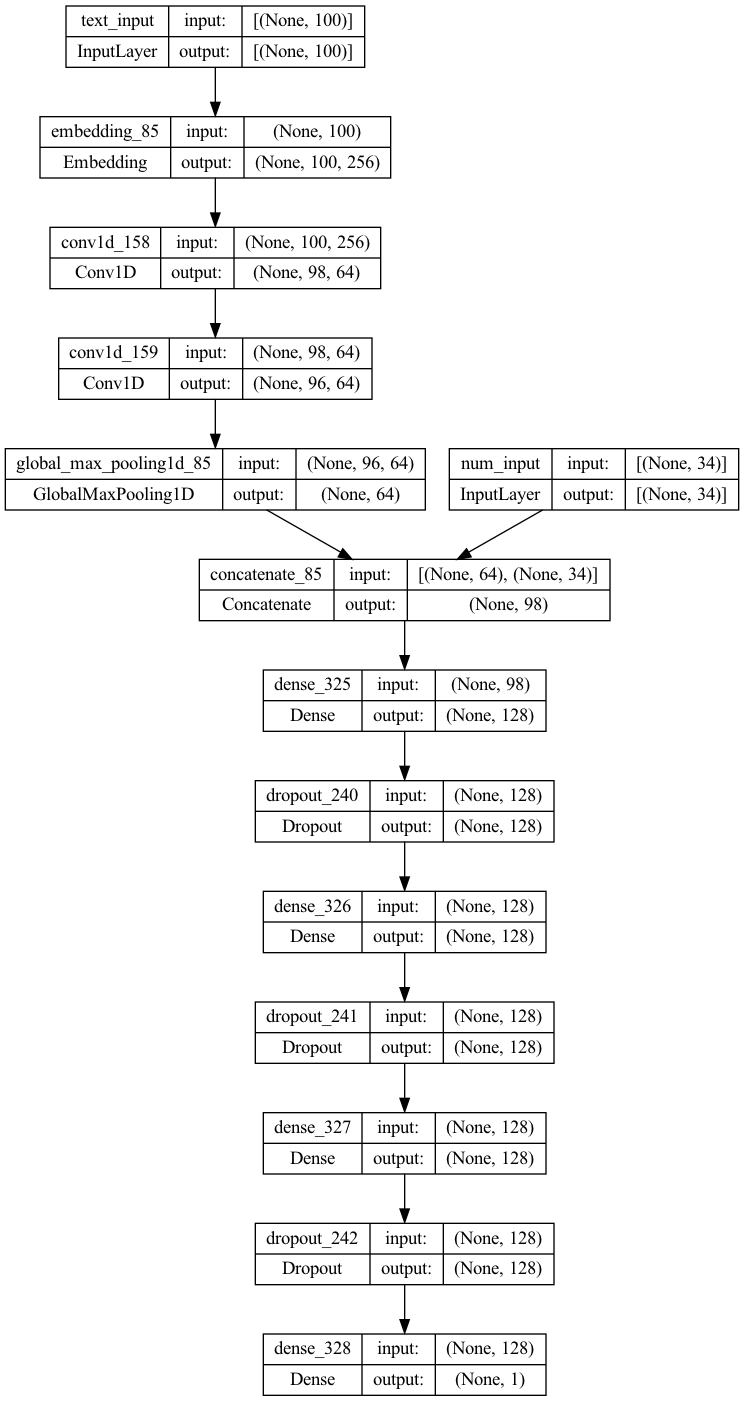

In [136]:
keras.utils.plot_model(best_model, '/Users/yihongan/Desktop/bestCNN_arch.png', show_shapes=True)

### Save the trained CNN

In [138]:
best_model.save('/Users/yihongan/Desktop/CNN.tf')

INFO:tensorflow:Assets written to: /Users/yihongan/Desktop/CNN.tf/assets


INFO:tensorflow:Assets written to: /Users/yihongan/Desktop/CNN.tf/assets


In [139]:
CNN = tf.keras.models.load_model('/Users/yihongan/Desktop/CNN.tf')